In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import kid_readout.roach.heterodyne
import time
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil
import kid_readout.utils.data_file

In [3]:
ri = kid_readout.roach.heterodyne.RoachHeterodyne()

In [4]:
all_resonances = np.array([1221.0, # double
                           1226.16,
                           1227.47,
                           1237.0,
                           1248.15,
                           1251.75, # double
                           1263.95,
                           1268.72,
                           1275.42,
                           1283.17,
                           1288.82,
                           1291.35,
                           1297.74,
                           1304.04,
                           1305.1,
                           1310.07,
                           1318.5,
                           1346.3,
                           1352.14,
                           1356.16,
                           1359.64,
                           1368.88,
                           1372.6,
                           1385.75,
                           1387.4,
                           1389.44,
                           1402.13, #double
                           1418.13,
                           1426.35,
                           1434.95,
                           1437.93,
                           1444.92,
                           1452.59,
                           
                           
             ])

In [5]:
all_resonances.shape

(33,)

In [6]:
initial_f0s = all_resonances[1:33]
initial_f0s.sort()
initial_f0s,initial_f0s.shape

(array([ 1226.16,  1227.47,  1237.  ,  1248.15,  1251.75,  1263.95,
         1268.72,  1275.42,  1283.17,  1288.82,  1291.35,  1297.74,
         1304.04,  1305.1 ,  1310.07,  1318.5 ,  1346.3 ,  1352.14,
         1356.16,  1359.64,  1368.88,  1372.6 ,  1385.75,  1387.4 ,
         1389.44,  1402.13,  1418.13,  1426.35,  1434.95,  1437.93,
         1444.92,  1452.59]), (32,))

In [7]:
#initial_f0s = np.array([  844.62890625,   864.90820312,   871.54882812,   879.3671875 ,
#         882.828125  ,   890.82421875,   900.59960938,   917.28320312,
#         945.18164062,   947.13085938,   950.08203125,   971.44140625,
#        1002.59375   ,  1015.2578125 ,  1026.98046875,  1039.18554688])

In [8]:
initial_atten = 3
atten_levels = [3]

In [9]:
ri.set_lo(1330)

In [10]:
ri.set_fft_gain(4)

In [11]:
ri.lo_frequency

1330

In [12]:
import kid_readout.utils.sweeps
reload(kid_readout.utils.sweeps)

<module 'kid_readout.utils.sweeps' from '/home/gjones/readout/kid_readout/kid_readout/utils/sweeps.pyc'>

In [13]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s,offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[ 1225.65625  ,  1226.96875  ,  1236.5      , ...,  1437.4296875,
         1444.421875 ,  1452.09375  ],
       [ 1225.6640625,  1226.9765625,  1236.5078125, ...,  1437.4375   ,
         1444.4296875,  1452.1015625],
       [ 1225.671875 ,  1226.984375 ,  1236.515625 , ...,  1437.4453125,
         1444.4375   ,  1452.109375 ],
       ..., 
       [ 1226.6328125,  1227.9453125,  1237.4765625, ...,  1438.40625  ,
         1445.3984375,  1453.0703125],
       [ 1226.640625 ,  1227.953125 ,  1237.484375 , ...,  1438.4140625,
         1445.40625  ,  1453.078125 ],
       [ 1226.6484375,  1227.9609375,  1237.4921875, ...,  1438.421875 ,
         1445.4140625,  1453.0859375]])

In [14]:
ri.set_dac_atten(initial_atten)

In [15]:
data_file = kid_readout.utils.data_file.DataFile(suffix='dark')

In [16]:
data_file.log_adc_snap(ri)
data_file.log_hw_state(ri)

In [17]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=16)
print time.time()-tic
data_file.add_sweep(swp)

detected mcnt overflow None 1343549 0 32768 0 144 1343549
detected mcnt overflow None 32969 0 32768 0 384 32969
detected mcnt overflow None 1343691 0 32768 0 224 1343691
detected mcnt overflow None 852173 0 32768 0 32 852173
135.150335073


'sweep_20150705041937'

In [18]:
def fit_sweeps(swp):
    resonators = []
    lo = swp.blocks[0].lo
    fig,axs = subplots(8,4,figsize=(18,12))
    fig2,axs2 = subplots(8,4,figsize=(18,12))
    for k in range(swp.sweep_indexes.max()+1):
        fr,s21,err = swp.select_index(k)
        ax = axs.flatten()[k]
        fr,s21,err = swp.select_index(k)
        s21c = s21*np.exp(swp.hardware_delay_estimate*1e6j*2*np.pi*(fr-swp.lo[0]))
        res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
        ax.plot(s21c.real,s21c.imag,'.-')
        modl = res.model(x=fr)
        ax.plot(modl.real,modl.imag,'.-')
        ax2 = axs2.flatten()[k]
        ax2.plot(fr,20*np.log10(np.abs(s21c)),'.-')
        ax2.plot(fr,20*np.log10(np.abs(modl)),'.-')
        resonators.append(res)
    return resonators

In [19]:
np.unique(swp.sweep_indexes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

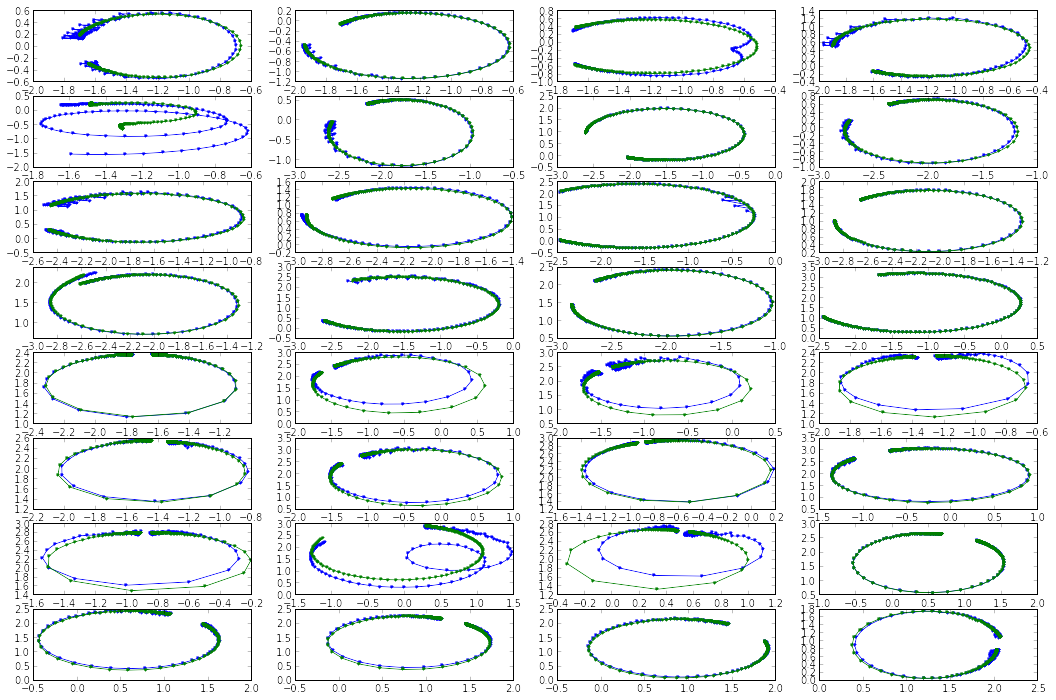

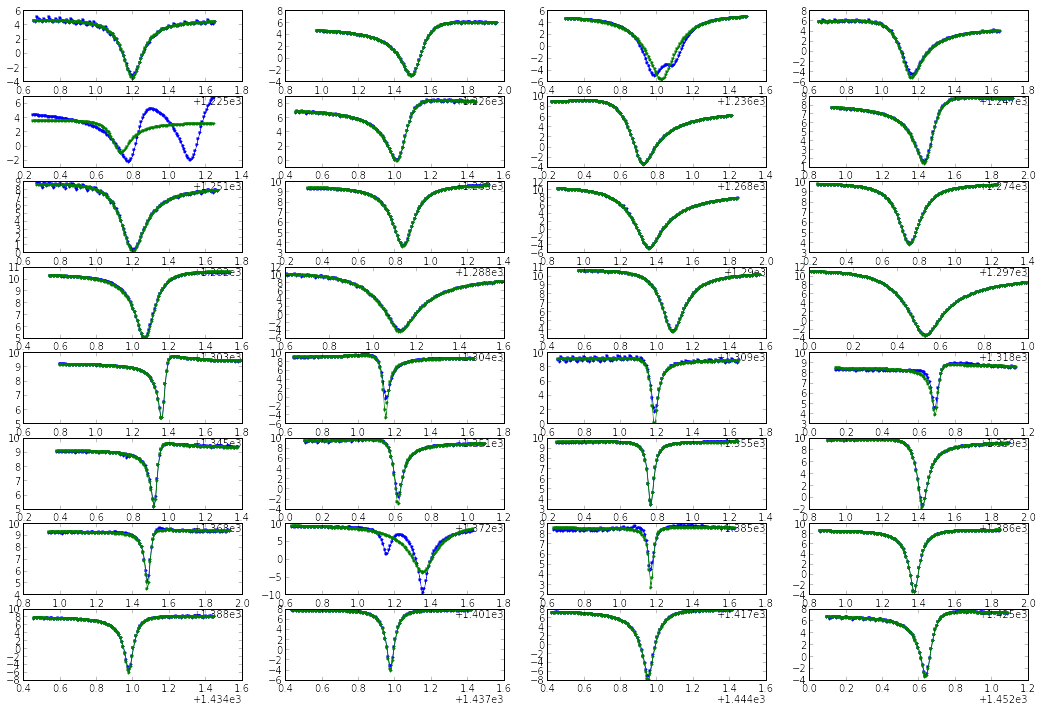

In [20]:
resonators = fit_sweeps(swp)

In [21]:
updated_f0s = np.array([res.f_0 for res in resonators])
Qs = np.array([res.Q for res in resonators])
fwhm = updated_f0s/(2*Qs)
(updated_f0s - initial_f0s)*1e3

array([  30.54991577,   66.82002197,   35.9203048 ,  -48.65261452,
        -32.21369814,  106.67655303,  -83.87608844,   43.67549582,
          4.40810478,   31.18960318,  -77.55904642,    4.49314   ,
         39.48356856,  -36.57653695,   -0.71422498,  -54.24419968,
         66.4609121 ,   -4.95260046,   16.63274646,   54.91286419,
         44.5562758 ,   -3.00510385,   12.40913691,   -0.6614089 ,
         42.48233501,  237.71307071,   37.07395567,   27.59495122,
         37.16351949,   45.6009219 ,   47.01162365,   67.2303773 ])

In [22]:
updated_f0s

array([ 1226.19054992,  1227.53682002,  1237.0359203 ,  1248.10134739,
        1251.7177863 ,  1264.05667655,  1268.63612391,  1275.4636755 ,
        1283.1744081 ,  1288.8511896 ,  1291.27244095,  1297.74449314,
        1304.07948357,  1305.06342346,  1310.06928578,  1318.4457558 ,
        1346.36646091,  1352.1350474 ,  1356.17663275,  1359.69491286,
        1368.92455628,  1372.5969949 ,  1385.76240914,  1387.39933859,
        1389.48248234,  1402.36771307,  1418.16707396,  1426.37759495,
        1434.98716352,  1437.97560092,  1444.96701162,  1452.65723038])

In [23]:
fwhm

array([ 0.10294223,  0.11043642,  0.1777024 ,  0.12504776,  0.07696205,
        0.0920842 ,  0.14214735,  0.08800414,  0.12908078,  0.09843461,
        0.2326409 ,  0.10232234,  0.08943351,  0.24056676,  0.11017584,
        0.23051674,  0.02520577,  0.03464927,  0.03459621,  0.02596279,
        0.02549755,  0.04888705,  0.0281255 ,  0.06418412,  0.02054979,
        0.19233608,  0.01990188,  0.07046916,  0.06757608,  0.0522972 ,
        0.1005862 ,  0.06534985])

In [24]:
ri.add_tone_freqs(updated_f0s)

bank_offset= 0 start_offset= 16777216 start_offset_bytes= 33554432
writing DRAM bank 0



array([ 1226.1875   ,  1227.5390625,  1237.0390625,  1248.1015625,
        1251.71875  ,  1264.0546875,  1268.6328125,  1275.4609375,
        1283.171875 ,  1288.8515625,  1291.2734375,  1297.7421875,
        1304.078125 ,  1305.0625   ,  1310.0703125,  1318.4453125,
        1346.3671875,  1352.1328125,  1356.1796875,  1359.6953125,
        1368.921875 ,  1372.59375  ,  1385.765625 ,  1387.3984375,
        1389.484375 ,  1402.3671875,  1418.1640625,  1426.375    ,
        1434.984375 ,  1437.9765625,  1444.96875  ,  1452.65625  ])

In [25]:
atten = 3
ri.set_dac_atten(atten)
data_file.log_adc_snap(ri)
data_file.log_hw_state(ri)
print "atten",atten
tic = time.time()
ri.select_bank(ri.tone_bins.shape[0]-1)
ri.select_fft_bins(range(ri.fft_bins.shape[1]))
ri._sync()
time.sleep(1)
print "ready to take data"


atten 3
ready to take data


In [26]:
t0 = time.time()
d,addr = ri.get_data(512)
tsg = data_file.add_timestream_data(d,ri,t0)
print time.time()-tic

detected mcnt overflow None 98506 0 65536 0 42864 98506
detected mcnt overflow None 98506 0 131072 1 108400 98506
detected mcnt overflow None 98506 0 196608 2 173936 98506
detected mcnt overflow None 98506 0 262144 3 239472 98506
115.061336994


In [27]:
data_file.close()

In [28]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

using NFFT: 2** 18.0
10

/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:173: ComplexWarning: Casting complex values to real discards the imaginary part
  Pxx[:,i] = np.conjugate(fx[:numFreqs]) * fx[:numFreqs]
/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:174: ComplexWarning: Casting complex values to real discards the imaginary part
  Pyy[:,i] = np.conjugate(fy[:numFreqs]) * fy[:numFreqs]
/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  S[0,k] = ss[0,0]



using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10
using NFFT: 2** 18.0
10


/home/gjones/readout/kid_readout/kid_readout/analysis/iqnoise.py:86: ComplexWarning: Casting complex values to real discards the imaginary part
  S[1,k] = ss[1,1]


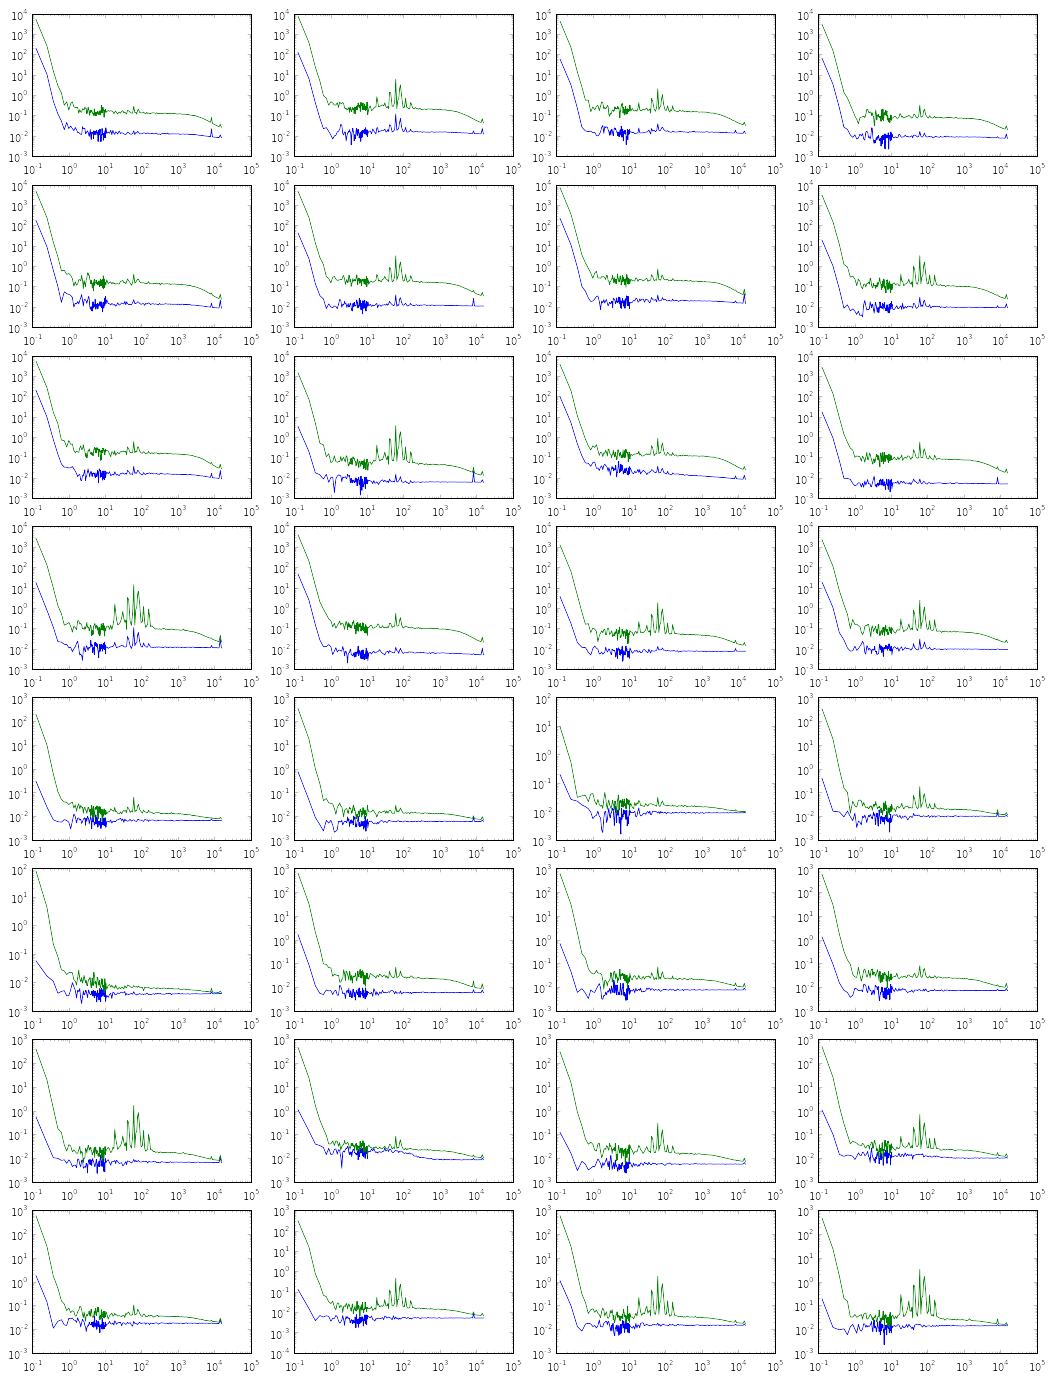

In [29]:
dmod=d
fig,axs = subplots(8,4,figsize=(18,24))
for k in range(32):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)

In [39]:
fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(dmod[:,1]-dmod[:,1].mean(),Fs=512e6/2**14,use_log_bins=False,use_full_spectral_helper=True)

#ax.loglog(fr,evals.T)

using NFFT: 2** 18.0


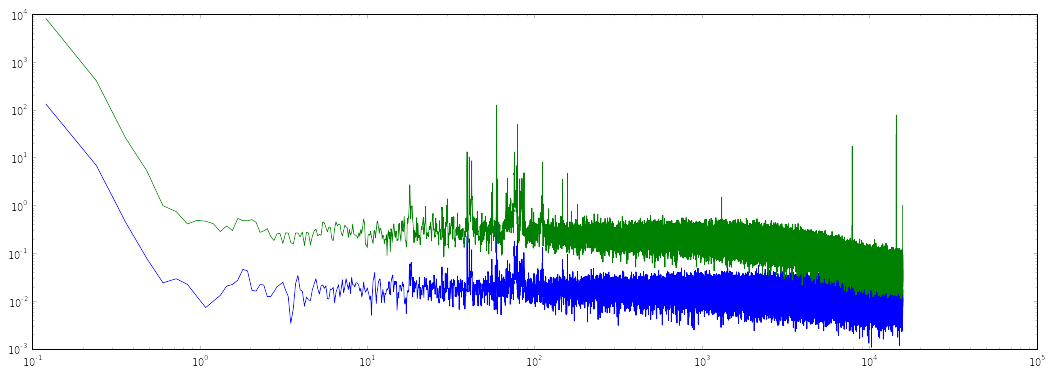

In [40]:
figure(figsize=(18,6))
loglog(fr,evals.T)

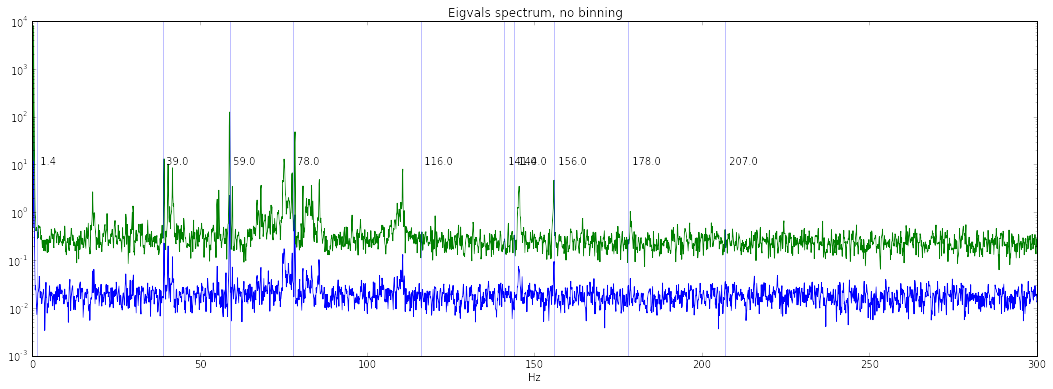

In [41]:
figure(figsize=(18,6))
semilogy(fr,evals.T)
xlim(0,300)
ax = gca()
for spur in [1.4,39,59,78,116,141,144,156,178,207]:
    ax.text(spur,10,(' %.1f' % spur))
    ax.axvline(spur,alpha=0.5)
xlabel('Hz')
title('Eigvals spectrum, no binning')

(0, 300)

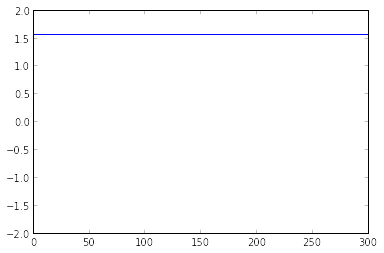

In [50]:
plot(fr,angles[0,:]-angles[1,:])
xlim(0,300)

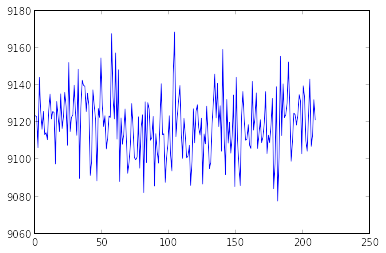

In [65]:
plot(dmod[::10000,0].imag)

In [34]:
[x.Q for x in resonators]

[5530.4204148254321,
 6510.3534008925653,
 4485.3100238556599,
 4987.9055398172059,
 6558.4197686496818,
 6689.5209862954944,
 4582.5894108131315,
 6855.0975380227137,
 5369.6667007546721,
 6335.6681161957913,
 2866.5493420870771,
 6267.436323946773,
 7799.667467864313,
 3664.6376472682095,
 6837.6014569421213,
 3309.7455378011678,
 23995.905051841237,
 16872.167905415681,
 17819.926273214827,
 22971.192316145749,
 22177.561470257955,
 12937.974859938417,
 20991.732389766814,
 11410.587577931896,
 26421.835839896547,
 6562.0849274461434,
 29443.11898784191,
 10882.958699017787,
 10666.48271589865,
 12871.174575511679,
 7441.1505216293026,
 11548.369943805703]

In [29]:
ri.tone_bins.shape

(129, 16)

In [ ]:
new_res = fit_sweeps(fine_swp)

In [46]:
fr,s21,err = fine_swp.select_index(0)
fr.ptp()

0.1240234375

In [47]:
new_f0s = np.array([res.f_0 for res in new_res])
newQs = np.array([res.Q for res in new_res])
fwhm = new_f0s/(2*newQs)
(new_f0s - initial_f0s)*1e3

array([ -2.75036198,  -8.36499499, -18.1566517 ,  27.45684   ,
        29.52417282,   6.18154885,  62.34624514,  -7.40309064,
        44.37014026,  -3.04533981,  11.30370433, -10.9906153 ,
        13.04140384, -44.33065046,  19.85448771,   7.9253936 ])

In [48]:
fwhm

array([ 0.02912425,  0.03078778,  0.02714933,  0.0302079 ,  0.02514165,
        0.02601062,  0.03599471,  0.02899567,  0.02582677,  0.02677329,
        0.03062127,  0.03108903,  0.01615045,  0.01502604,  0.01341793,
        0.01315327])

In [49]:
[res.delay for res in new_res]

[0.45141720942144958,
 0.094586777665206123,
 0.014686151981272174,
 0.017796887808216814,
 0.00043724074656971993,
 0.011191579245233058,
 0.0094185496420942927,
 0.05758960001641613,
 -0.0033176609419354351,
 0.007291893632622024,
 0.0079508120551642324,
 -0.00077998325721197539,
 0.0041570727965430238,
 0.00093343481198936889,
 -0.00047656048102172777,
 0.011198239856341578]

In [50]:
newQs

array([ 14505.90628717,  14051.54439249,  16057.1507388 ,  14488.21970183,
        17494.86702526,  16935.31803672,  12267.80757015,  15367.16899379,
        17442.06407264,  16906.71882743,  14983.23560798,  14786.38738301,
        29272.02800418,  31527.12783064,  35416.04611583,  36629.2168434 ])

In [51]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

In [52]:
new_f0s

array([ 844.94724964,  865.23163501,  871.88184335,  875.31745684,
        879.69952417,  880.99618155,  883.15234625,  891.16259691,
        900.94437014,  905.29695466,  917.6113037 ,  919.38900938,
        945.5130414 ,  947.45566935,  950.41985449,  963.58792539])

In [53]:
ri.set_tone_freqs(new_f0s,nsamp=2**18)

bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([ 844.94726562,  865.23242188,  871.8828125 ,  875.31835938,
        879.69921875,  880.99609375,  883.15234375,  891.16210938,
        900.9453125 ,  905.296875  ,  917.61132812,  919.38867188,
        945.51367188,  947.45507812,  950.41992188,  963.58789062])

In [55]:
ri.select_fft_bins(range(16))

In [64]:
ri.set_dac_atten(10)

In [65]:
dmod,addr = ri.get_data(128)

detected mcnt overflow None 1310485 0 32768 0 26224 1310485


In [57]:
dmod.shape

(524288, 16)

In [26]:
import kid_readout.analysis.iqnoise
import kid_readout.utils.despike

In [30]:
dmod = d

using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10
using NFFT: 2** 16.0
10


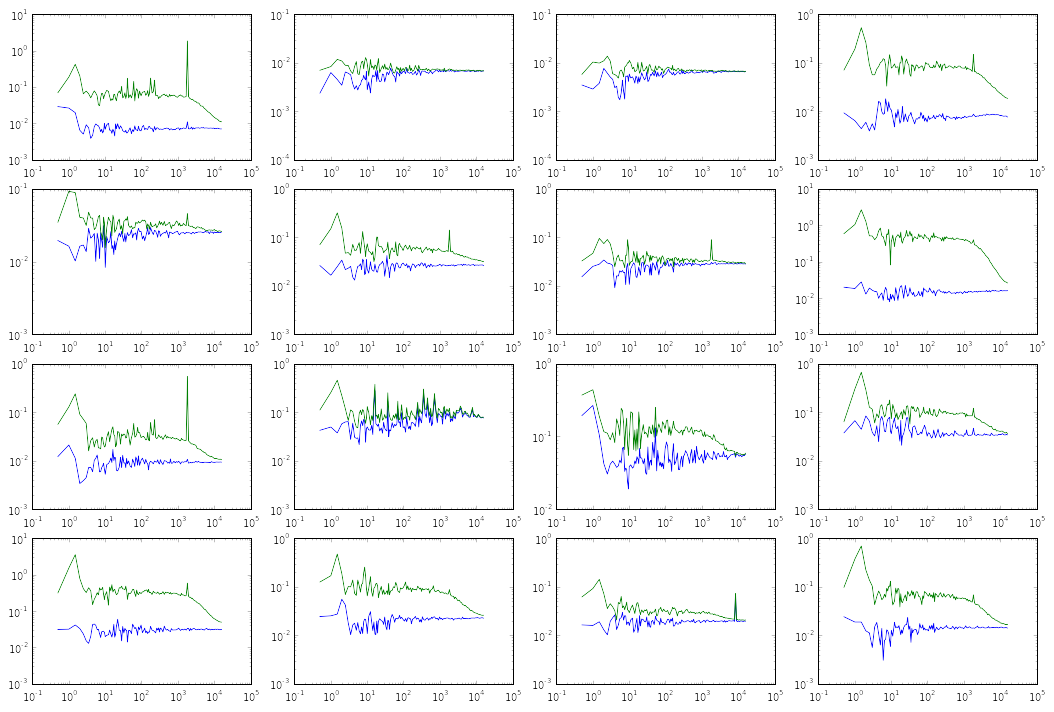

In [31]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    despike = kid_readout.utils.despike.deglitch_window(dmod[:,k]-dmod[:,k].mean(),2**14)
    fr,S,evals,evects,angles,piq=kid_readout.analysis.iqnoise.pca_noise(despike,Fs=512e6/2**14)
    ax.loglog(fr,evals.T)
#    ax.xaxis.set_scale('symlog')

In [76]:
ts = dmod[:,3]
despike = kid_readout.utils.despike.deglitch_window(dmod[:,3]-dmod[:,3].mean(),2**14)

In [79]:
Qs

array([ 14512.79042247,  13616.48574293,  15691.05110949,  14375.85548433,
        17343.44571994,  17473.09661493,  12115.91118983,  15196.59562753,
        17542.05628817,  16683.89496554,  14765.47493265,  14619.13718965,
        27945.16383875,  29094.679821  ,  33561.02764402,  34569.66638804])

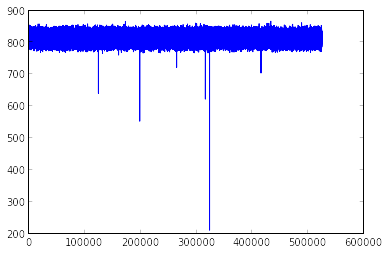

In [68]:
plot(np.abs(ts))

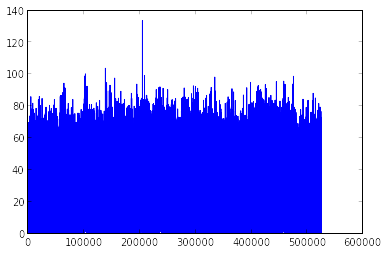

In [74]:
plot(np.abs(despike))

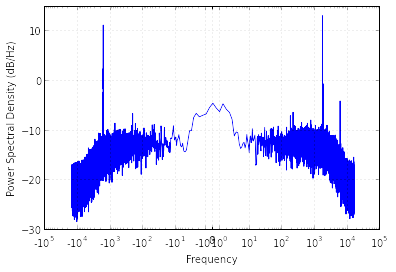

In [77]:
blah = psd(despike,NFFT=2**16,Fs=512e6/2**14)
xscale('symlog')

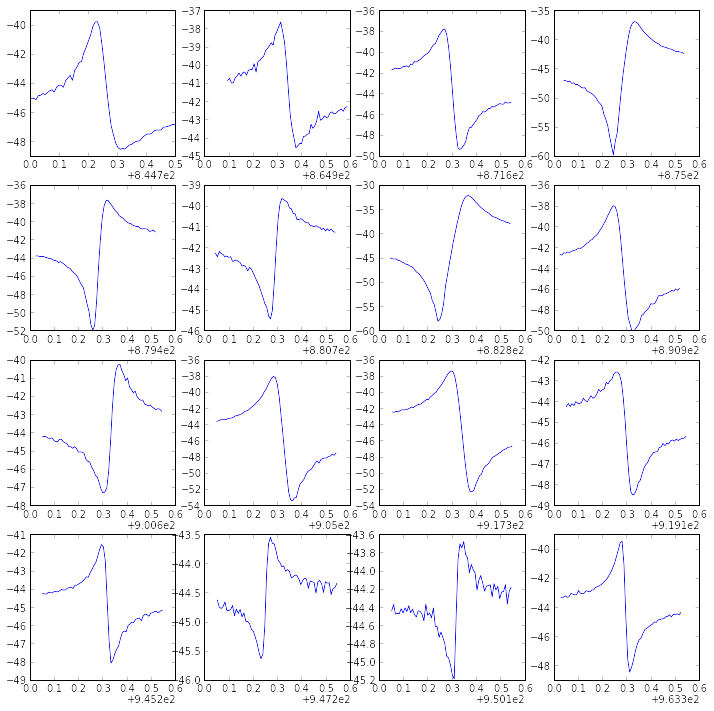

In [124]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    ax.plot(fr,20*np.log10(np.abs(s21)))

In [125]:
import kid_readout.analysis.resonator
import kid_readout.analysis.khalil

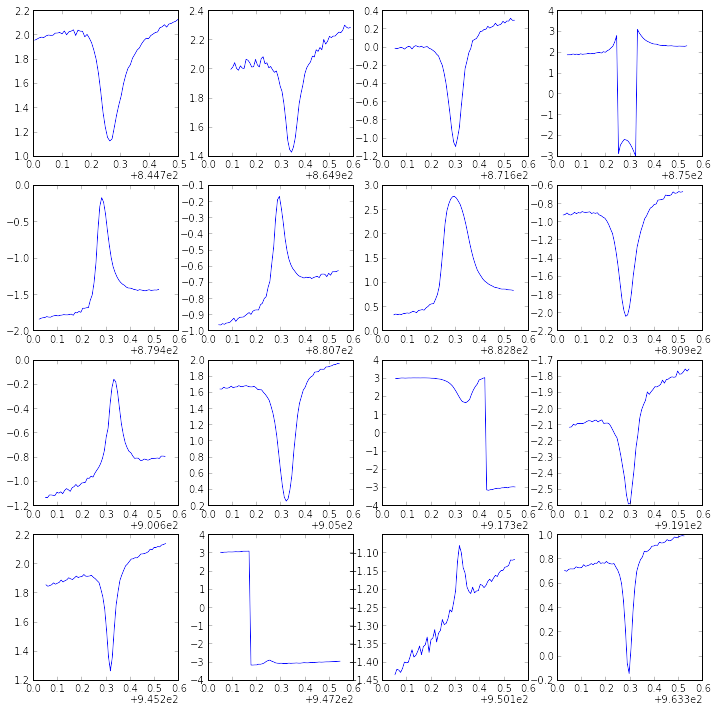

In [126]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(fr,np.angle(s21c))

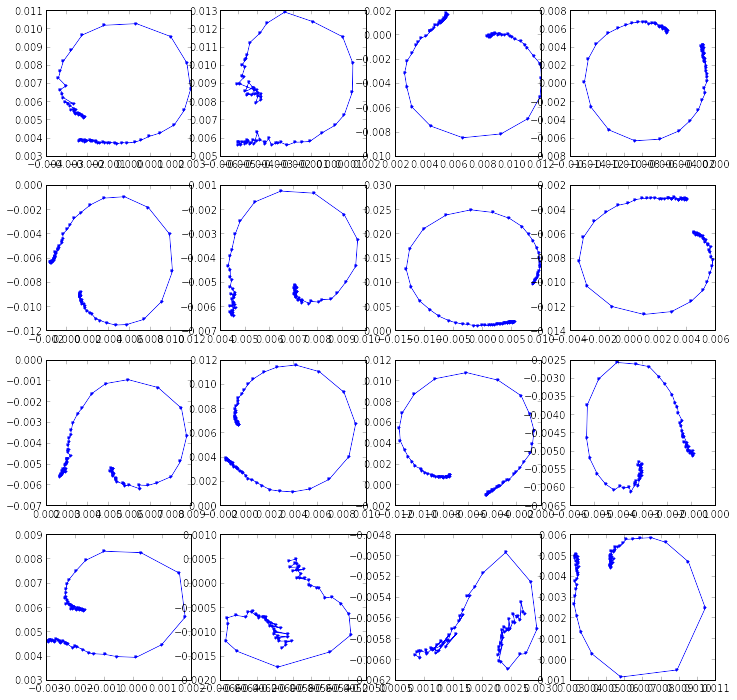

In [127]:
fig,axs = subplots(4,4,figsize=(12,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.2j*2*np.pi*(fr-ri.lo_frequency))
    ax.plot(s21c.real,s21c.imag,'.-')

845.1953125 844.703125
14509.7893985 14510.444072 0.472129867535 -12322.2285727 0.0800919642239
865.484375 864.9921875
13217.4273966 13217.884756 0.760819793999 -17047.7298542 0.0100592267738
872.140625 871.6484375
15307.4575411 16953.022477 783.67883999 -11089.3188141 0.000493518101752
875.53125 875.0390625
13887.2248591 31777.5032586 1563.03520456 6009.36525281 0.0160531714692
879.9140625 879.421875
16758.0974406 29862.4133242 3680.38495625 11269.6055095 0.00194483158019
881.234375 880.7421875
16811.7420033 20299.9183079 7482.62873315 26001.8731006 0.00126192586539
883.3359375 882.84375
11713.1545005 28560.3193672 898.400288419 4127.01665023 -0.00358999245783
891.4140625 890.921875
14772.6694893 14773.5314117 0.368098003745 -9654.26705551 0.0142959632228
901.140625 900.6484375
16935.1407938 17823.343019 1244.08575013 20523.9908142 -0.00552956651021
905.5390625 905.046875
16206.3700044 18077.653404 444.903903596 -8334.11105078 0.00199650798053
917.84375 917.3515625
14529.9086211 16900

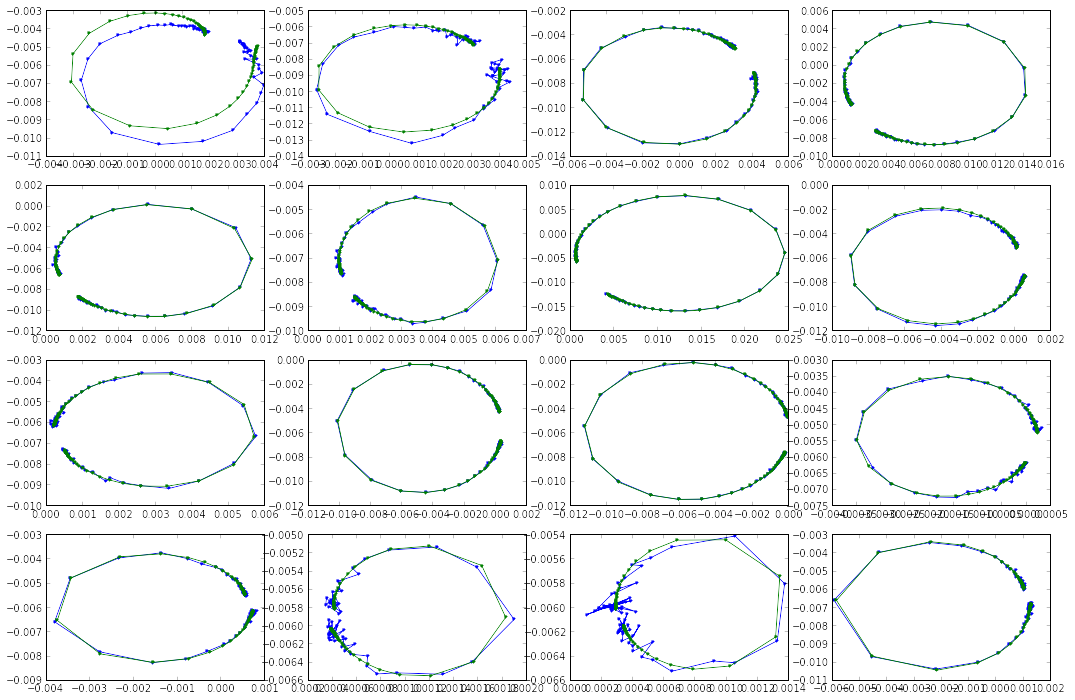

In [132]:
fig,axs = subplots(4,4,figsize=(18,12))
for k in range(16):
    ax = axs.flatten()[k]
    fr,s21,err = swp.select_index(k)
    s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
    print fr.max(),fr.min()
    res = kid_readout.analysis.resonator.fit_best_resonator(fr,s21c,errors=err,min_a=1.0)
    ax.plot(s21c.real,s21c.imag,'.-')
    modl = res.model(x=fr)
    ax.plot(modl.real,modl.imag,'.-')
    print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
    try:
        ax.set_title(str(res.a))
    except:
        pass

879.9140625 879.421875
16824.6691064 30191.5952085 3740.63904884 11320.6719853 -0.000457328720674


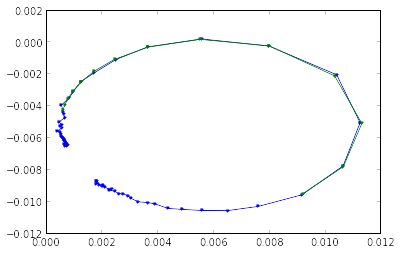

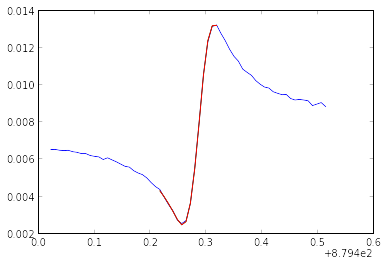

In [129]:
ax = gca()
fr,s21,err = swp.select_index(4)
s21c = s21*np.exp(-31.3j*2*np.pi*(fr-ri.lo_frequency))
print fr.max(),fr.min()
res = kid_readout.analysis.resonator.fit_best_resonator(fr[25:-25],s21c[25:-25],errors=err[25:-25],min_a=1.0)
ax.plot(s21c.real,s21c.imag,'.-')
modl = res.model(x=res.freq_data)
ax.plot(modl.real,modl.imag,'.-')
print res.Q,res.Q_i,res.Q_e_real,res.Q_e_imag,res.delay
figure()
plot(fr,np.abs(s21c))
plot(res.freq_data,np.abs(modl))
plot(res.freq_data,np.abs(res.model(x=res.freq_data)))


In [96]:
1/(1/res.Q-1/np.abs(res.Q_e_real+1j*res.Q_e_imag))

36322.665100510239

In [97]:
res.Q

13711.847040231984

In [98]:
res.Q_i

15899.183778596402

In [41]:
blks = [blk for blk in swp.blocks if blk.sweep_index==2]

In [42]:
blk = blks[0]

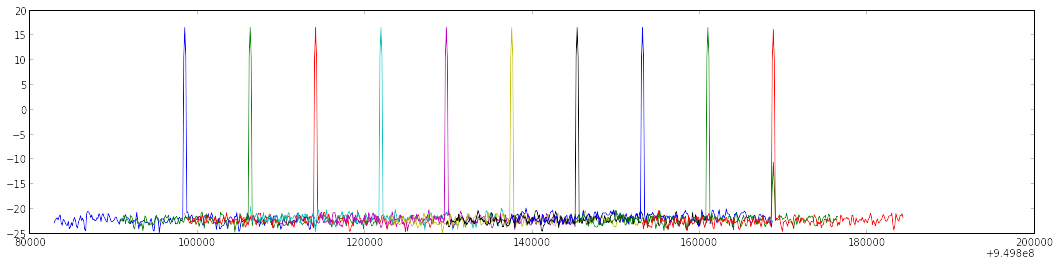

In [52]:
figure(figsize=(18,4))
for blk in blks[:10]:
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))

In [48]:
len(blks)

128

In [53]:
by_index = [[blk for blk in swp.blocks if blk.sweep_index==k] for k in range(16)]

(944000000.0, 951000000.0)

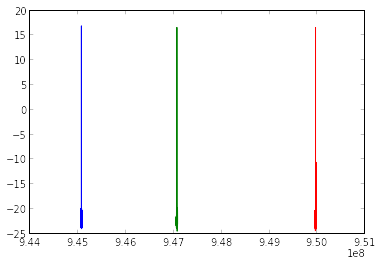

In [58]:
for idx in range(16):
    blk = by_index[idx][8]
    pxx,frl = mlab.psd(blk.data,Fs=512e6/2**14)
    f1 = blk.tone*512e6/blk.nsamp
    plot(frl+f1+930e6,10*np.log10(pxx))
xlim(944e6,951e6)

In [60]:
fr,s21,err = swp.select_index(2)

In [61]:
fr.min()

949.8984375

In [62]:
initial_f0s[14:15]

array([ 950.4])

In [63]:
nsamp = 2**16
df = 512./nsamp
kid_readout.utils.sweeps.prepare_sweep(ri,center_freqs=initial_f0s[14:15],offsets=np.arange(-64,64)*df,
                                       nsamp=nsamp)


bank_offset= 0 start_offset= 0 start_offset_bytes= 0
writing DRAM bank 0



array([[ 949.8984375],
       [ 949.90625  ],
       [ 949.9140625],
       [ 949.921875 ],
       [ 949.9296875],
       [ 949.9375   ],
       [ 949.9453125],
       [ 949.953125 ],
       [ 949.9609375],
       [ 949.96875  ],
       [ 949.9765625],
       [ 949.984375 ],
       [ 949.9921875],
       [ 950.       ],
       [ 950.0078125],
       [ 950.015625 ],
       [ 950.0234375],
       [ 950.03125  ],
       [ 950.0390625],
       [ 950.046875 ],
       [ 950.0546875],
       [ 950.0625   ],
       [ 950.0703125],
       [ 950.078125 ],
       [ 950.0859375],
       [ 950.09375  ],
       [ 950.1015625],
       [ 950.109375 ],
       [ 950.1171875],
       [ 950.125    ],
       [ 950.1328125],
       [ 950.140625 ],
       [ 950.1484375],
       [ 950.15625  ],
       [ 950.1640625],
       [ 950.171875 ],
       [ 950.1796875],
       [ 950.1875   ],
       [ 950.1953125],
       [ 950.203125 ],
       [ 950.2109375],
       [ 950.21875  ],
       [ 950.2265625],
       [ 95

In [70]:
ri.set_dac_atten(40)

In [71]:
tic = time.time()
swp = kid_readout.utils.sweeps.do_prepared_sweep(ri,nchan_per_step=1)
print time.time()-tic

detected mcnt overflow None 22667977 0 2048 0 16 22667977
55.4558930397


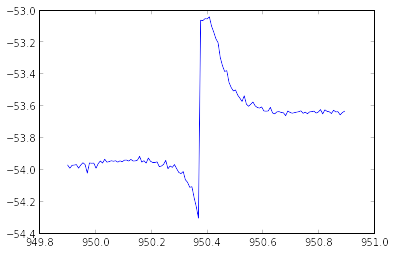

In [72]:
plot(swp.freqs,20*np.log10(np.abs(swp.data)))